In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

0

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 7367 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['0_Normal', '1_Covid19', '2_Pneumonia']

In [8]:
len(dataset)

231

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 0], dtype=int32)>>


2024-04-26 11:33:08.355398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[55.56673   55.56673   55.56673  ]
  [57.818027  57.818027  57.818027 ]
  [59.539726  59.539726  59.539726 ]
  ...
  [58.2245    58.2245    58.2245   ]
  [54.881508  54.881508  54.881508 ]
  [51.41992   51.41992   51.41992  ]]

 [[59.727543  59.727543  59.727543 ]
  [59.12696   59.12696   59.12696  ]
  [59.68422   59.68422   59.68422  ]
  ...
  [57.920547  57.920547  57.920547 ]
  [56.567387  56.567387  56.567387 ]
  [53.503906  53.503906  53.503906 ]]

 [[59.16797   59.16797   59.16797  ]
  [60.7884    60.7884    60.7884   ]
  [60.932747  60.932747  60.932747 ]
  ...
  [57.60573   57.60573   57.60573  ]
  [58.12887   58.12887   58.12887  ]
  [55.896374  55.896374  55.896374 ]]

 ...

 [[ 6.804577   6.804577   6.804577 ]
  [ 6.8180275  6.8180275  6.8180275]
  [ 8.         8.         8.       ]
  ...
  [ 3.2341156  3.2341156  3.2341156]
  [ 3.9814644  3.9814644  3.9814644]
  [ 3.7418556  3.7418556  3.7418556]]

 [[ 8.432613   8.432613   8.432613 ]
  [ 9.4844055  9.4844055  

2024-04-26 11:33:11.413641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-26 11:33:16.148307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


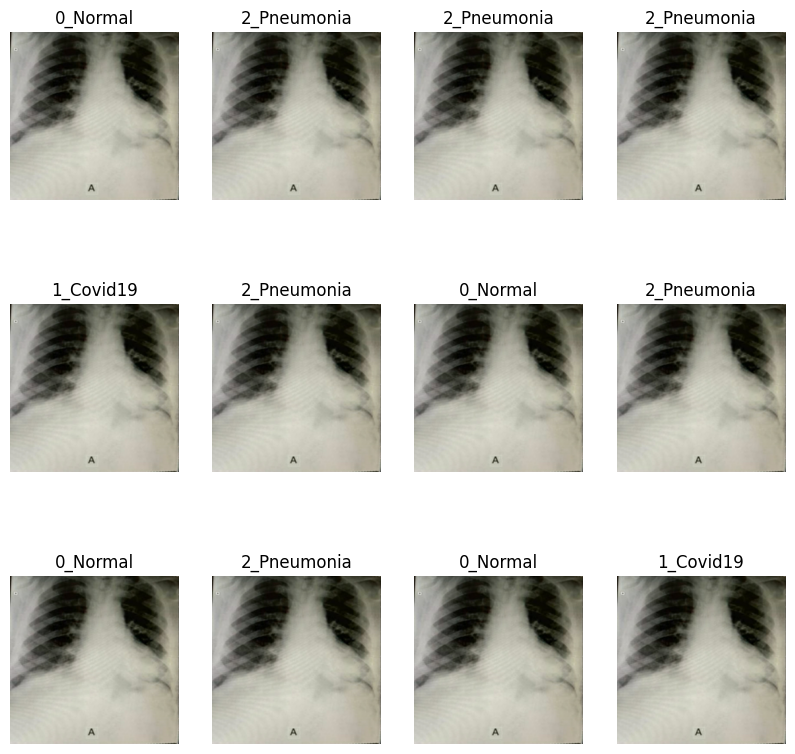

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(3):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [12]:
train_size=0.8
len(dataset)*train_size

184.8

In [13]:
train_ds=dataset.take(1766)
train_ds
len(train_ds)

231

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split *ds_size)
    val_size=int(val_split *ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
len(train_ds)

231

In [15]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

184

In [17]:
len(val_ds)

23

In [18]:
len(test_ds)

24

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/224)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 20

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 20)               │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,852 (722.08 KB)

 Trainable params: 184,852 (722.08 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/50


2024-04-26 11:34:33.958042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 203 of 10000
2024-04-26 11:34:35.621384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-26 11:34:35.705411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4197 - loss: 2.1500

2024-04-26 11:47:40.604777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 224 of 10000
2024-04-26 11:47:40.889285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-26 11:47:41.516341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


184/184 ━━━━━━━━━━━━━━━━━━━━ 822s 4s/step - accuracy: 0.4199 - loss: 2.1452 - val_accuracy: 0.5231 - val_loss: 0.9672
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.4934 - loss: 1.0006 - val_accuracy: 0.5231 - val_loss: 0.9662
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.4993 - loss: 0.9993 - val_accuracy: 0.5231 - val_loss: 0.9638
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3968s 22s/step - accuracy: 0.4971 - loss: 0.9949 - val_accuracy: 0.5231 - val_loss: 0.9896
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.5069 - loss: 0.9960 - val_accuracy: 0.5231 - val_loss: 0.9654
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 663s 4s/step - accuracy: 0.5094 - loss: 0.9896 - val_accuracy: 0.5231 - val_loss: 0.9672
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.4987 - loss: 0.9952 - val_accuracy: 0.5231 - val_loss: 0.9789
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.5162 - loss: 0.9827 - val_accuracy: 0.5

In [28]:
score= model.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.3967 - loss: 3.3061


In [29]:
score

[3.2105038166046143, 0.4231770932674408]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 184}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc=history.history['accuracy']
val_acc =history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [35]:
for image_batch,labels_batch in test_ds.take(1):
    
    print(image_batch[0].numpy())

[[[ 0.16796875  0.16796875  0.16796875]
  [ 2.          2.          2.        ]
  [ 2.0352669   2.0352669   2.0352669 ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.62955475  0.62955475  0.62955475]
  [ 1.9365196   1.9365196   1.9365196 ]
  [ 1.9563675   1.9563675   1.9563675 ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.230793    0.230793    0.230793  ]]

 [[ 1.5800781   1.5800781   1.5800781 ]
  [ 1.4339256   1.4339256   1.4339256 ]
  [ 0.5800781   0.5800781   0.5800781 ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.5313606   0.5313606   0.5313606 ]]

 ...

 [[ 0.40647125  0.40647125  0.40647125]
  [ 6.3919144   6.3919144   6.3919144 ]
  [13.343197   13.343197   13.343197  ]
  ...
  [13.487175   13.487175   13.487175  ]
  [13.959648   13.959648   13.959648  ]
  [11.251953   11.251953   11.251953  ]]

 [

2024-04-26 22:43:35.892914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-26 22:43:39.227357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


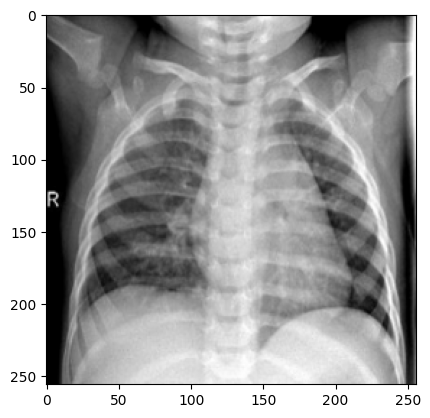

In [36]:
for image_batch,labels_batch in test_ds.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: 0_Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
[9.8004091e-01 1.9534636e-02 4.2442125e-04 9.9532991e-31 1.8923941e-32
 8.3225162e-38 1.5339192e-29 8.7038850e-28 2.5046417e-34 7.3453060e-35
 2.3779201e-22 8.7651685e-26 5.2372632e-31 1.1319439e-28 1.6593293e-20
 1.5748323e-34 1.7568256e-34 1.8603187e-27 3.5146462e-37 3.0101279e-36]
predicted label: 0_Normal


2024-04-26 22:43:43.538391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


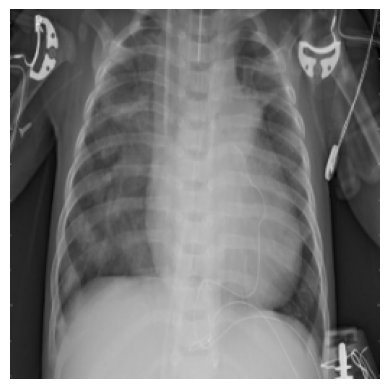

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2024-04-26 22:44:36.990099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


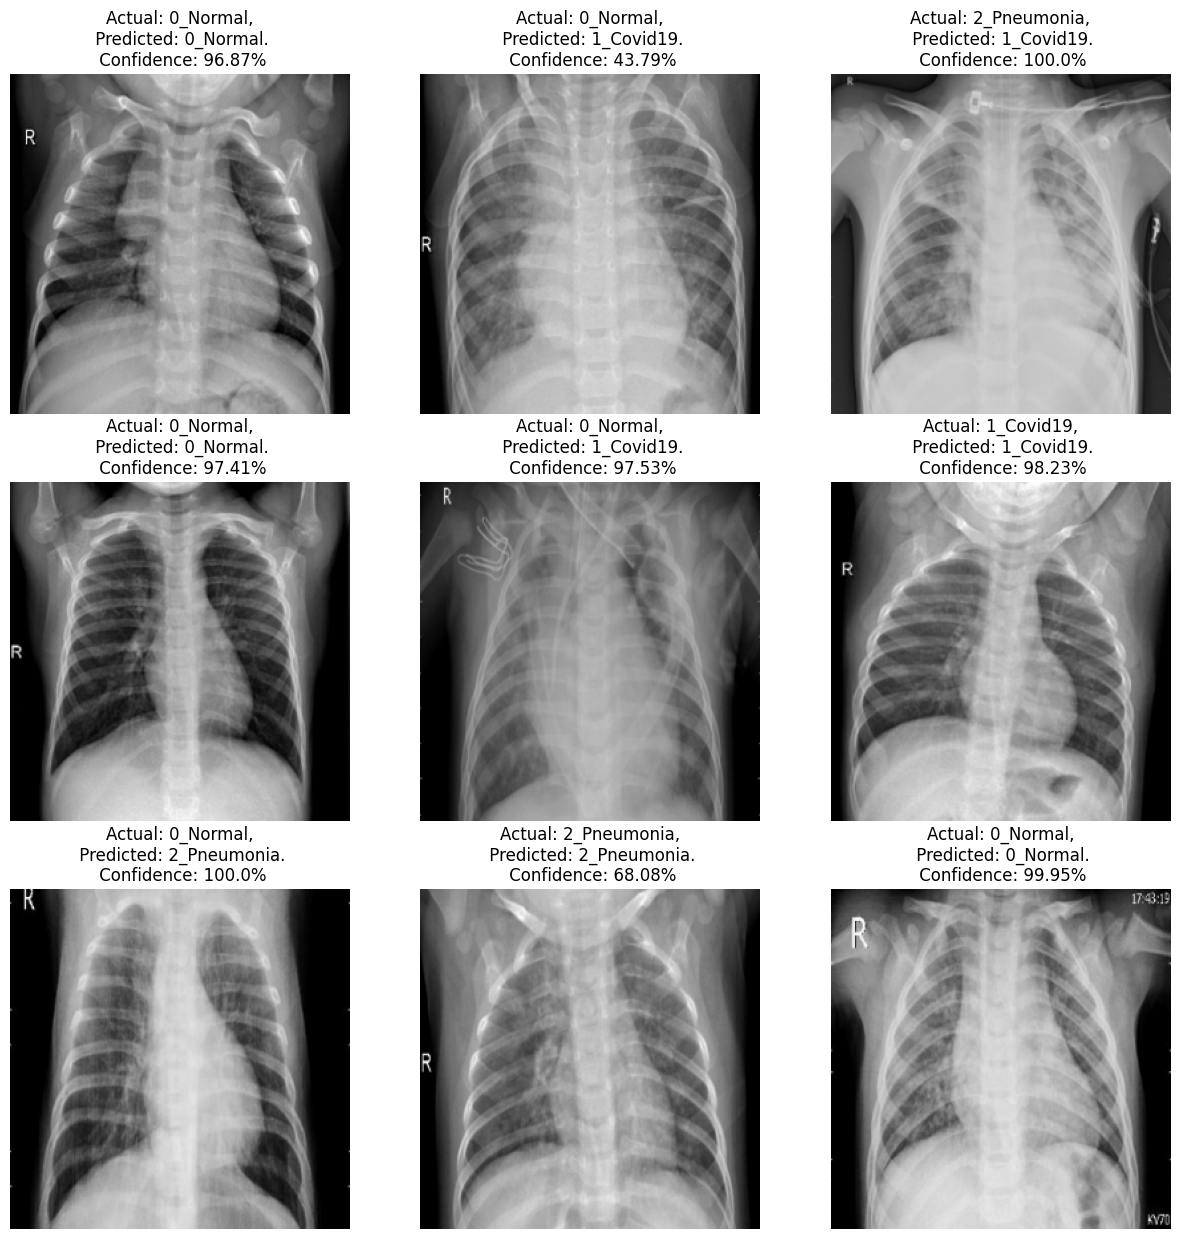

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
import os

model_version = 1
model_dir = "./model1"

# Check if the directory exists, create it if not
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Now proceed with finding existing models in the directory
for filename in os.listdir(model_dir):
    try:
        version = int(filename)
        model_version = max(model_version, version)
    except ValueError:
        pass
model_version += 1

# Save the trained model (choose either .h5 or .keras extension)
model.save(f"{model_dir}/{model_version}.h5")  # Use .h5 for HDF5 format
# or
# model.save(f"{model_dir}/{model_version}.keras")  # Use .keras for native Keras format

print(f"Model saved to: {model_dir}/{model_version}.h5")

Model saved to: ./model1/2.h5
